## Data mining and Machine Learning

We are going to focus on three kinds of problems: *Classification*, *Clustering* and *Dimensionality Reduction*.  Each of these problems is used in both Data mining and Machine learning to draw conclusions about the data.  Let us explain each of these settings on different sections.

### Classification

Classification is an example of *supervised learning*:  There is a set of *training data* with an attribute that classifies it in one of several categories.  The goal is to find the value of that attribute for new data. 

For example, with our running database, we could use all the data from the year 2013 to try to figure out which financial complaints get solved positively for the customer, which ones get solved without relief, and which ones remain _in progress_.  This will offer us a good insight on, for instance, which companies are faster to respond to consumer complaints positively, if there are states where complaints are less likely to get resolved, etc.

Let us start by finding the kind of company responses observed in the database.


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
    
%matplotlib inline

data = pd.read_csv("Consumer_Complaints.csv", low_memory=False, parse_dates=[8,9])

print data['Company response'].unique()

['Closed with non-monetary relief' 'In progress' 'Closed with explanation'
 'Closed with monetary relief' 'Closed' 'Untimely response'
 'Closed without relief' 'Closed with relief']


These are eight different categories, and our target for deciding the fate of future complaints.  Let us create a set of training data, by gathering all complaints formulated during the year 2013, and keeping only the columns that we believe are relevant to the decision-making process: 

* The product and sub-product that originate the complaint.
* The issue (but not the sub-issue) that consumers had with the product.
* State (but not ZIP code) where the complaint was filed.
* Method of submission of the complaint.
* The company that offered the service.

The size of this training data will dictate which algorithm we use for classification.  We will then try to classify all complaints formulated during the year 2014.

> Before the data can be processed, we need to encode non-numerical labels so they can be properly treated by the different classifying algorithms.  We do that with the class `LabelEncoder` from the module `sklearn.preprocessing`.

In [3]:
in_2013 = data['Date received'].map(lambda t: t.year==2013)
in_2014 = data['Date received'].map(lambda t: t.year==2014)
df = data[in_2013 | in_2014]
df['Year'] = df['Date received'].map(lambda t: t.year)
irrelevant = ['Date received', 'Date sent to company', 'Complaint ID',
              'Timely response?', 'Consumer disputed?', 'Sub-issue',
              'ZIP code']
df.drop(irrelevant, 1, inplace=True)
df = df.dropna()

from sklearn.preprocessing import LabelEncoder

encoder = {}

for column in df.columns:
    if df[column].dtype != 'int':
        le = LabelEncoder()
        le.fit(df[column].unique())
        df[column] = le.transform(df[column])
        encoder[column] = le

training = df[df.Year==2013]
target = training['Company response']
training.drop(['Company response', 'Year'], 1, inplace=True)

test = df[df.Year==2014]
true_result = test['Company response']
test.drop(['Company response', 'Year'], 1, inplace=True)

len(training)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: SettingWithCopy

77100

#### Support Vector Classification.

The training data is not too big (anything less than 100,000 is considered manageable).  For this volume of training data, it is suggested that we employ *support vector classification* with a linear kernel.  Three flavors of this algorithm are coded as classes in the module `sklearn.svm` (for *support vector machines*): `SVC`, `NuSVC`, and a simplified version of `SVC` with linear kernel, `LinearSVC`, which is what we need.

In [4]:
from sklearn.svm import LinearSVC
 
clf = LinearSVC()
clf.fit(training, target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

We are ready to evaluate the performance of this classifier.


In [5]:
clf.predict(test)==true_result

0         False
2         False
3          True
4          True
6         False
7          True
9          True
11        False
12        False
13        False
14        False
15         True
16         True
20        False
21        False
23        False
24         True
25        False
26        False
27        False
28        False
30        False
31        False
32        False
33         True
35        False
36        False
38         True
39         True
42         True
          ...  
101574     True
101577     True
101579     True
101582    False
101583     True
101586     True
101590     True
101592     True
101594     True
101595     True
101597     True
101598     True
101601     True
101602     True
101603    False
101604     True
101607    False
101610     True
101611     True
101613     True
101614     True
101616     True
101617     True
101618     True
101620     True
101621     True
101622     True
101625     True
101626     True
101627     True
Name: Company response, 

In [6]:
float(sum(_))/float(len(_))

0.7985509022395147

With this method, we classify correctly almost 80% of the complaints.

> In the rare cases where this method does not work, we can always resort to plain `SVC` or its `NuSVC` variation with a carefully chosen kernel.

The power of a classifier lies in the applications.  For instance, if we would like to purchase via web a _conventional fixed mortgage_ from the Bank of America in the state of South Carolina, and we fear problems with _settlement process and cost_, what does the classifier tells us about our chances to have the matter settled?


In [7]:
print encoder['Product'].transform(['Mortgage'])[0]

print encoder['Sub-product'].transform(['Conventional fixed mortgage'])[0]

print encoder['Issue'].transform(['Settlement process and costs'])[0]

print encoder['State'].transform(['SC'])[0]

print encoder['Submitted via'].transform(['Web'])[0]

print encoder['Company'].transform(['Bank of America'])[0]

4
5
27
50
5
247


In [8]:
clf.predict([4,5,27,50,5,247])

array([1])

In [9]:
encoder['Company response'].inverse_transform(_)[0]

'Closed with explanation'

A satisfactory outlook. 

#### Trees

It is possible to create a *decision tree* illustrating a set of rules to facilitate the classification.  In the `scikit-learn` toolkit we have a class implemented for this purpose---`DecisionTreeClassifier` in the submodule `sklearn.tree`.  Let us see it in action.

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(training, target)

clf.predict(test) == true_result

0          True
2         False
3          True
4          True
6         False
7          True
9          True
11        False
12        False
13        False
14        False
15         True
16         True
20        False
21        False
23        False
24         True
25        False
26        False
27        False
28        False
30        False
31        False
32        False
33         True
35        False
36        False
38         True
39         True
42         True
          ...  
101574     True
101577     True
101579     True
101582    False
101583     True
101586    False
101590     True
101592     True
101594     True
101595    False
101597     True
101598     True
101601     True
101602     True
101603     True
101604     True
101607     True
101610     True
101611     True
101613     True
101614     True
101616     True
101617     True
101618     True
101620     True
101621     True
101622     True
101625     True
101626    False
101627     True
Name: Company response, 

In [11]:
float(sum(_)) / len(_)

0.739882356545449

It looks like this simple classifier was successful in predicting the outcome of about 74% of the complaints in 2014.  

> It is possible to create a `dot` file readable with Graphviz visualization software (www.graphviz.org).  

In [12]:
from sklearn.tree import export_graphviz

export_graphviz(clf, out_file="tree.dot")

Opening this file in `Graphviz` gives us an impressive set of rules.  The following is a detail of the tree (too large to fit in these pages!).

<img src="tree.png">

We also have implementations of *random forests* and *extremely randomized trees*, both of them within the submodule `sklearn.ensemble`.  The corresponding classes are called `RandomForestClassifier` and `ExtraTreesClassifier`, respectively.

In any of the previous cases, the coding of the classifier is exactly as in the cases of the SVC and the basic decision trees.

#### Naive Bayes

Similar results are obtained with Naive Bayes methods.  In the module `sklearn.naive_bayes` we have three implementations of this algorithm:

* The class `GaussianNB` for the Gaussian Naive Bayes, where the likelihood of the features is assumed to be Gaussian.
* The class `BernoulliNB` for Naive-Bayes for data distributes according to multivariate Bernoulli distributions (each feature is assumed to be a binary valued variable).
* The class `MultinomialNB` for multinomially distributed data.

#### Nearest Neighbors

For an even better result for this case, we employ *classification by nearest neighbors*.  This is exactly the same procedure we employed in the setting of Computational Geometry to perform the corresponding geometric query problem.  In this setting, note how we have coded our data as points in a Euclidean space of high dimension, and we may thus translate those methods for this classification purpose.  The advantage in this case, is that we not necessarily must use Euclidean distances for our computations.  For instance, since the data is essentially different regardless of its numerical value, it makes sense to impose a Hamming metric to calculate distance between labels.  We have a generalization of the nearest neighbors algorithm implemented as the class `KNeighborsClassifier` in the module `sklearn.neighbors`.


In [13]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=8, metric='hamming')
clf.fit(training, target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='hamming',
           metric_params=None, n_neighbors=8, p=2, weights='uniform')

In [14]:
clf.predict(test)==true_result

0          True
2         False
3          True
4          True
6         False
7          True
9          True
11        False
12        False
13        False
14        False
15         True
16         True
20        False
21        False
23        False
24         True
25        False
26        False
27        False
28        False
30        False
31        False
32        False
33         True
35        False
36        False
38         True
39         True
42         True
          ...  
101574     True
101577     True
101579     True
101582    False
101583     True
101586     True
101590     True
101592     True
101594     True
101595     True
101597     True
101598     True
101601     True
101602     True
101603    False
101604     True
101607    False
101610     True
101611     True
101613     True
101614     True
101616     True
101617     True
101618     True
101620     True
101621     True
101622     True
101625     True
101626     True
101627     True
Name: Company response, 

In [15]:
float(sum(_))/len(_)

0.791274777120799

More than 79% of success.

### Dimensionality Reduction

Data often observes internal structure, but high dimension (number of columns, in a sense) makes difficult the procedure of extracting and selecting this internal structure.  Often, it is possible to perform smart projections of this data on lower-dimensional manifolds, and analyze these projections for search of features.  We refer to this technique as *Dimensionality reduction*.  

Let us observe how to profit from these processes with our running example.  We gather all the daily complains by product, and analyze the data.

> For this example, we decided to drop all dates that contain any `NaN`.  This reduced significantly the volume of the data, making the subsequent study and results simpler to understand.  For a more elaborate and complete study, force all occurrences of `NaN` to be zeros (substitute the method `dropna()` with `fillna(0)`).

In [16]:
df = data.groupby(['Date received', 'Product']).size()
df = df.unstack().dropna()

df.head()

Product,Bank account or service,Consumer loan,Credit card,Credit reporting,Debt collection,Money transfers,Mortgage,Payday loan,Student loan
Date received,,,,,,,,,
2013-11-06,66,14,41,62,129,2,153,2,14
2013-11-07,44,11,33,43,99,2,128,8,10
2013-11-08,49,11,36,44,83,8,113,12,7
2013-11-09,9,4,20,19,33,2,23,3,4
2013-11-11,15,4,23,32,68,2,46,2,14


In [17]:
df.shape

(233, 9)

We may regard this data as 233 points in a space of 9 dimensions.  

#### Principal Component Analysis

For this small kind of data, and without any other prior information, one of the best procedures of dimensionality reduction results in projecting over a 2-dimensional plane.  But not just any plane---we seek one projection that ensures that the projected data has the largest possible variance.   We accomplish that with the information we obtain from eigenvalues and eigenvectors of a matrix that represents our data.  This process is called *principal component analysis* (*PCA* for short).

> This process is regarded as one of the most useful techniques in Statistical methods.  For an amazing survey of theory (in both scopes of Linear Algebra and Statistics), coding techniques and applications, the best resource is the second edition of the book  _Principal Component Analysis_, written by I.T. Jolliffe and published by Springer in their _Springer Series in Statistics_ in 2002.

> We have an implementation in the `scikit-learn` toolkit, the class `PCA`, in the submodule `sklearn.decomposition`.



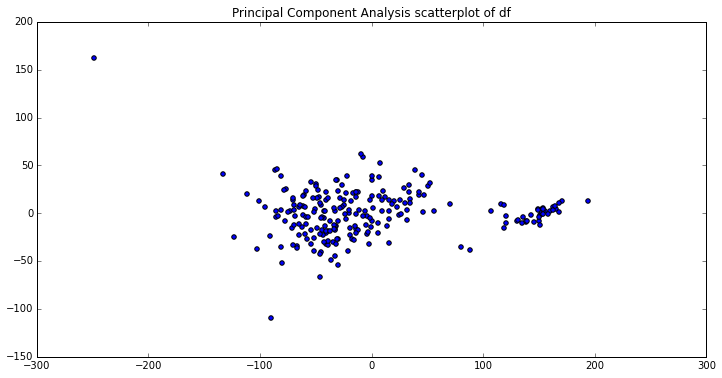

In [18]:
from sklearn.decomposition import PCA

model = PCA(n_components=2)

model.fit(df)
PCA(copy=True, n_components=2, whiten=False)

projected_df = model.transform(df)

plt.figure(figsize=(12,6))
plt.scatter(projected_df[:,0], projected_df[:,1])
plt.title('Principal Component Analysis scatterplot of df')
plt.show()

Observe how the data consists on two very-well differentiated clusters of points---one of them considerably larger than the other---and some outliers.  We will come back to this problem in the next section.

#### Isometric Mappings

We don't necessarily need to project on hyperplanes.  One neat trick is to assume that the data itself lies on a non-linear sub-manifold, and obtain a representation of this object with the points on it.  This gives us flexibility to search for projections where the projected data satisfies relevant properties.  For instance, if we require the projections to maintain geodesic distance among points (whenever possible), we achieve a so-called *isometric mapping* (*isomap* for short).   In the `scipy` stack, we have an implementation of this method as the class `Isomap` in the submodule `sklearn.manifold`. 

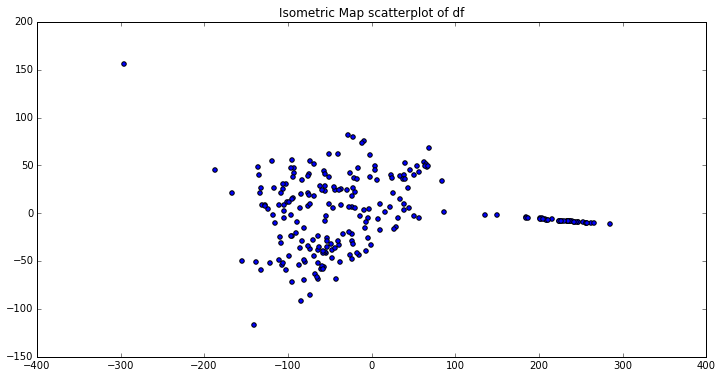

In [20]:
from sklearn.manifold import Isomap

model = Isomap().fit(df)

isomapped_df = model.transform(df)

plt.figure(figsize=(12,6))
plt.scatter(isomapped_df[:,0], isomapped_df[:,1])
plt.title('Isometric Map scatterplot of df')
plt.show()

Although visually very different, this method also offers us two very clear clusters, one of them much larger than the other.  The smaller cluster appears as a sequence of points clearly aligned.

#### Spectral Embedding

Another possibility is to embed the data non-linearly by applying spectral analysis on an affinity/similarity matrix.  The results carry similar quality as the previous two examples.

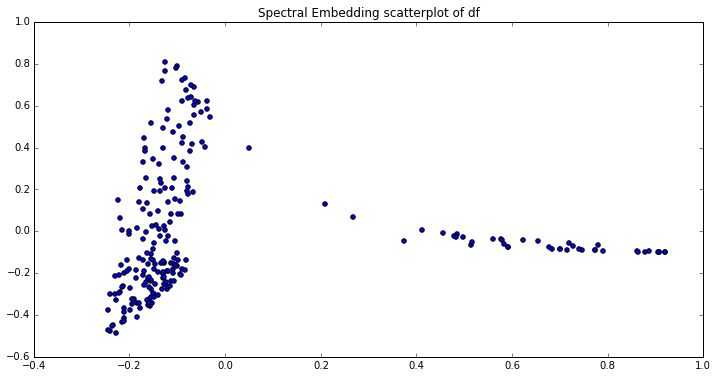

In [22]:
from sklearn.manifold import SpectralEmbedding

model = SpectralEmbedding().fit(df)

embedded_df = model.embedding_

plt.figure(figsize=(12,6))
plt.scatter(embedded_df[:,0], embedded_df[:,1])
plt.title('Spectral Embedding scatterplot of df')
plt.show()

In this case, the clusters are more clearly defined than in the previous examples.

#### Locally Linear Embedding

Another possible projection, similar in some sense to isometric maps, seeks to preserve the distance within local neighborhoods---the *locally linear embedding*.  We have an implementation through the class 'LocallyLinearEmbedding', again within the submodule `sklearn.manifold`.

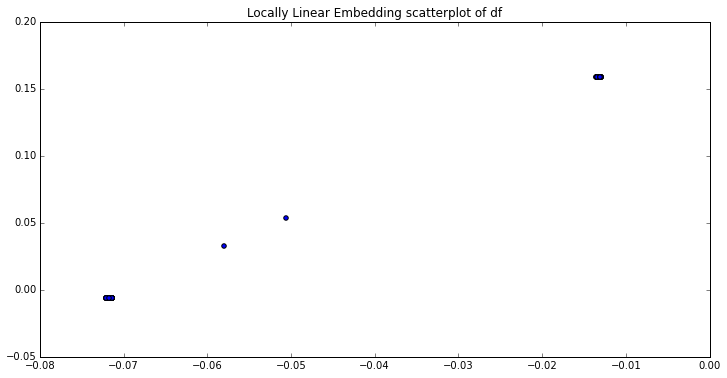

In [24]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding().fit(df)

lle_df = model.transform(df)

plt.figure(figsize=(12,6))
plt.scatter(lle_df[:,0], lle_df[:,1])
plt.title('Locally Linear Embedding scatterplot of df')
plt.show()

Note the extremely conglomerated two clusters, and two outliers.

### Clustering 

Similar in some sense to the problem of classification, yet more complex.  When facing a dataset, we acknowledge the possibility of having some hidden structure, in a way that will allow us to predict the behavior of future data.  Searching for this structure is performed by finding common patterns and gathering data conforming to those patterns in different clusters.  For this reason, we also refer to this problem as *data mining*.

There are many different methods to perform clustering, depending on the volume of data, and the a priori information we have on the number of clusters.

#### MeanShift

We employ the technique of *Mean Shift* clustering when the data does not exceed 10,000 points, and we do not know a priori the number of clusters we need.  Let us experiment with the running example from the section on dimensionality reduction, but we will remain oblivious from the two clusters suggested by all projections.  We will let the mean shift clustering take that decision for us.

We have an implementation in the `scipy` stack through the class `MeanShift` in the submodule `sklearn.cluster` of the `scikit-learn` toolkit.  One of the ingredients of this algorithm is approximation with radial basis functions (discussed in *chapter 1*), for which we need to provide an appropriate bandwidth.  The algorithm, if not provided with one, will try to estimate from the data.  This process could potentially be very slow and expensive, and it is generally a good idea to do an estimation by ourselves, so we can control resources.  We may do so with the helper function `estimate_bandwidth`, in the same submodule.

> The implementation of classes and routines for clustering algorithms in the `scikit-learn` toolkit require the data to be fed as a `numpy` array, rather than a `pandas` data frame.  We may perform this switch easily with the `dataframe` method `.values`.

In [25]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(df.values, n_samples=1000)

model = MeanShift(bandwidth=bandwidth, bin_seeding=True)

model.fit(df.values)

MeanShift(bandwidth=69.993157716732171, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, seeds=None)

At this point, the object `model` has successfully computed a series of labels and attached them to each point in the data, so they are properly clustered.  We may allow some _unclassifiable_ points to remain unclassified---we accomplish this by setting the optional Boolean flag `cluster_all` to `False`.  By default, the algorithm forces every single piece of data into a cluster.  Let us find the number of labels and visualize the result on top of one of the projections from the previous section, for quality purposes.

In [26]:
np.unique(model.labels_)      # how many clusters?

array([0, 1, 2])

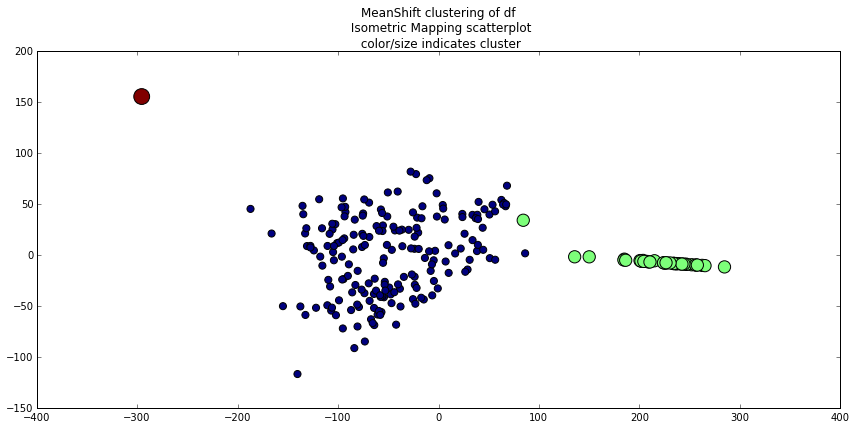

In [27]:
plt.figure(figsize=(12,6))
plt.scatter(isomapped_df[:,0], isomapped_df[:,1], c=model.labels_, s = 50 + 100*model.labels_)
plt.title('MeanShift clustering of df\n Isometric Mapping scatterplot\n color/size indicates cluster')
plt.tight_layout()
plt.show()

Note how the two clear clusters are correctly computed, and one outlier received its own cluster.

Let us find out what is the significance of these clusters.   First, the outlier.

In [28]:
df[model.labels_ == 2]

Product,Bank account or service,Consumer loan,Credit card,Credit reporting,Debt collection,Money transfers,Mortgage,Payday loan,Student loan
Date received,,,,,,,,,
2014-06-26,117,19,89,85,159,5,420,7,12


What is so different in the amount of complaints produced on July 26th, 2014?  Let us produce a plot with the each cluster of dates, to see if we may guess what the differences are about.

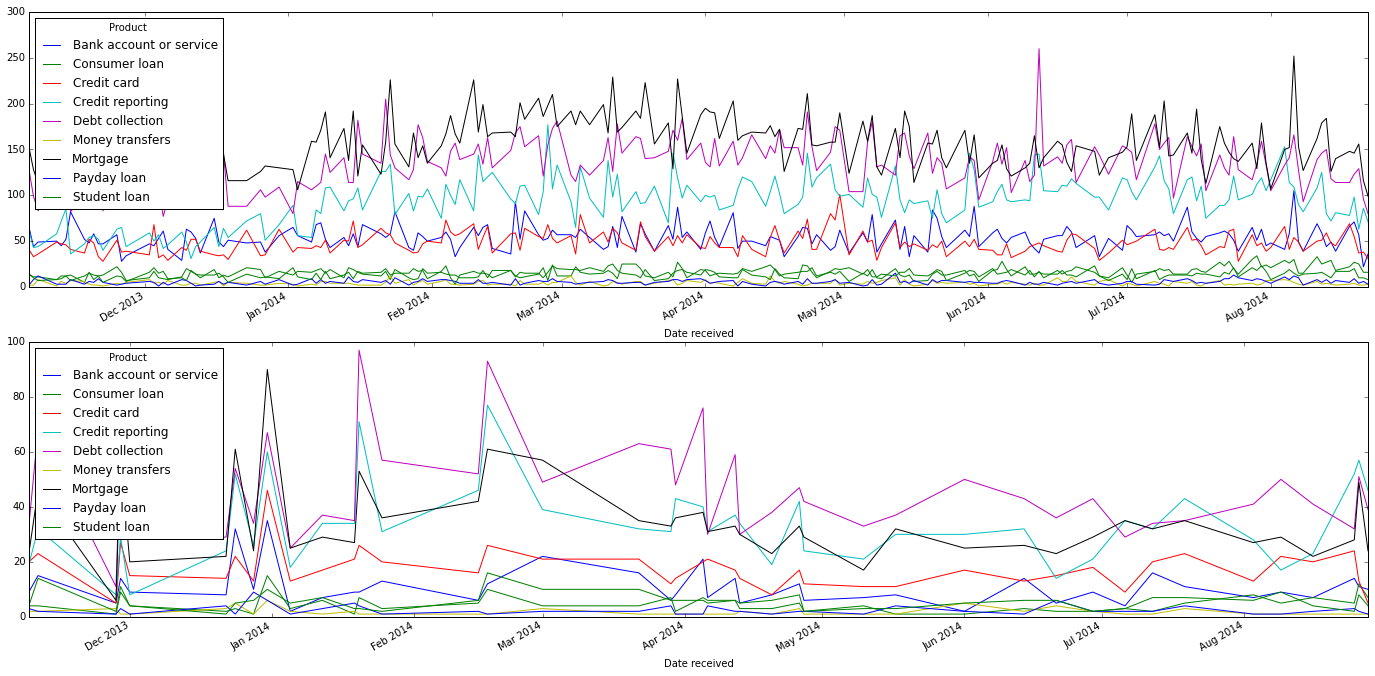

In [30]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
df[model.labels_==0].plot(ax=ax1)
df[model.labels_==1].plot(ax=ax2)
plt.show()

Visually, it appears as if the cluster has been formed by gathering dates with high volume of complaints, versus low-volume of complaints.  But not only that.  A closer inspection reveals that on dates from cluster 0, mortgages are unequivocally the number one reason for complaint.  On the other hand, for dates in cluster 1, complaints on mortgages get relegated to a second or third position, always behind debt collection and payday loans.


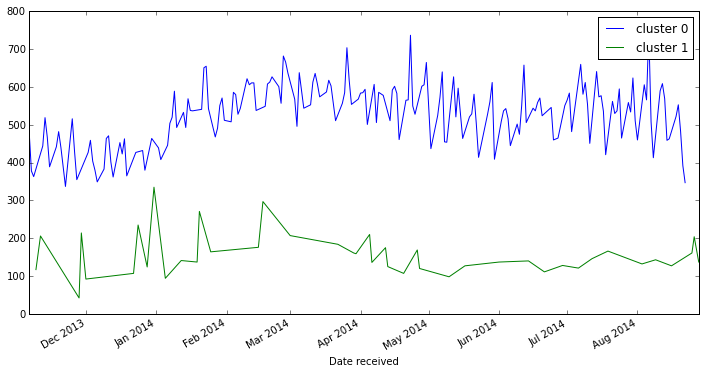

In [31]:
plt.figure(figsize=(12,6))
df[model.labels_==0].sum(axis=1).plot(label='cluster 0')
df[model.labels_==1].sum(axis=1).plot(label='cluster 1')
plt.legend()
plt.show()


Indeed, that was the case

In [32]:
df[model.labels_==0].sum(axis=1).describe()

count    190.000000
mean     528.605263
std       80.900075
min      337.000000
25%      465.000000
50%      537.000000
75%      585.000000
max      748.000000
dtype: float64

In [33]:
df[model.labels_==1].sum(axis=1).describe()

count     42.000000
mean     156.738095
std       56.182655
min       42.000000
25%      124.250000
50%      140.500000
75%      175.750000
max      335.000000
dtype: float64

In [34]:
df[model.labels_==2].sum(axis=1)

Date received
2014-06-26    913
dtype: float64

Note that the volume of complaints in the cluster labeled 1 does not go over 335 daily complaints.  Complaints formulated on days from the zero cluster are all between 337 and 748.  On the outlier date---July 26th, 2014---there were 913 complaints.

#### Gaussian Mixture Models

*Gaussian mixture models* are probabilistic models that make assumptions on the way the data has been generated, and the distributions it obeys.  These algorithms approximate the parameters defining the involved distributions.   

In its purest form, this method implements the *expectation-maximization* algorithm (*EM* for short) in order to fit the model.  We access this implementation with the class `GMM` in the submodule `sklearn.mixtures` of the `scikit-learn` toolkit.  This implementation requires us to provide with the number of desired clusters, though.  And unlike other methods, it will try its hardest to categorize the data into as many clusters required, no matter whether these artificial clusters make any logical sense.

In order to perform clustering on relatively small amounts of data without knowledge a priori of the number of clusters that we need, we may employ a variant of Gaussian mixture models that use variational inference algorithms instead.  We call this a *variational Gaussian mixture*.  We have an implementation of this algorithm as the class `VBGMM` in the same submodule.

For this particular method, we do need to feed an upper bound of the number of clusters we expect, but the algorithm will compute the optimal number for us.

For instance, in our running example---that clearly shows two clusters---we are going to impose an upper bound of 30, and observe the behavior of the `VBGMM` algorithm.

In [36]:
from sklearn.mixture import VBGMM

model = VBGMM(n_components=30).fit(df)

labels = model.predict(df)

len(np.unique(labels))    # how many clusters?

2

Only two clusters!


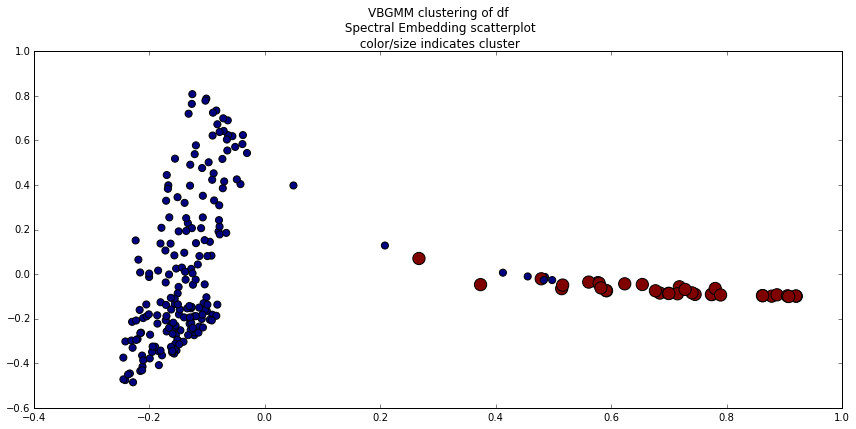

In [37]:
a, b = np.unique(labels)

sizes = 50 + 100 * (labels - a) / float(b-a)

plt.figure(figsize=(12,6))
plt.scatter(embedded_df[:,0], embedded_df[:,1], c=labels, s=sizes)
plt.title('VBGMM clustering of df\n Spectral Embedding scatterplot\n color/size indicates cluster')
plt.tight_layout()
plt.show()

#### K-means

If we know a priori the number of clusters that we require, regardless of the amount of data, a good algorithm for clustering is Lloyd's algorithm (better known as the method of *K-means*).  

In the module `scipy.cluster.vq` we have an efficient set of routines for k-means clustering, generating code books from k-means models, and quantizing vectors by comparing them with centroids in a code book. Also, a parallel-capable algorithm is implemented as the class `KMeans` in the submodule `sklearn.cluster` of the `scikit-learn` toolkit.

For instance, if we require on our data a partition into 4 clusters, using all CPU's of our computer, we could issue from the toolkit the following code.


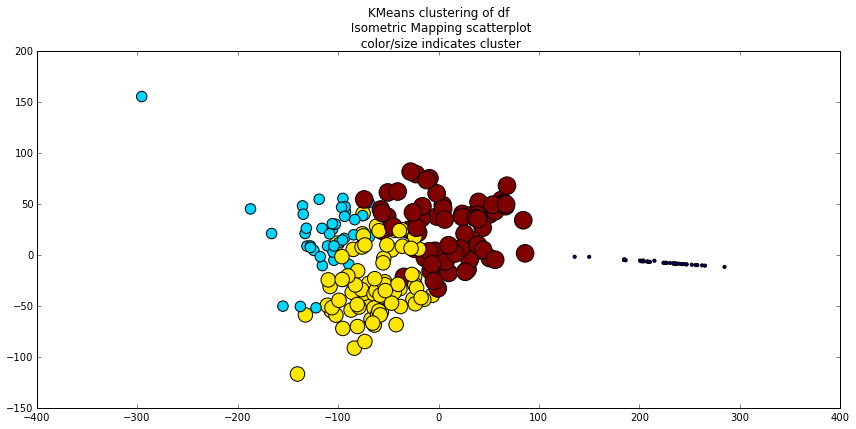

In [39]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, n_jobs=-1).fit(df)

plt.figure(figsize=(12,6))
plt.scatter(isomapped_df[:,0], isomapped_df[:,1], c=model.labels_, s=10 + 100*model.labels_)
plt.title('KMeans clustering of df\n Isometric Mapping scatterplot\n color/size indicates cluster')
plt.tight_layout()
plt.show()

Note how this artificial clustering still manages to categorize different dates by the volume of complaints received, no matter the product.

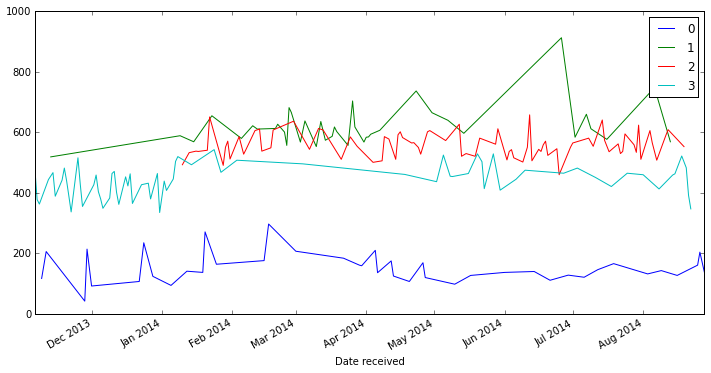

In [40]:
plt.figure(figsize=(12,6))

for label in np.unique(model.labels_):
    if sum(model.labels_==label) > 1:
        df[model.labels_==label].sum(axis=1).plot(label=label)

plt.legend()
plt.show()

> The cluster that has not been represented in this plot is, as in our previous clustering analysis, the single date "July 26, 2014," when nearly a thousand complaints were received.

In case of huge amounts of data (more than 10,000 points), we often use a variation of KMeans that runs on randomly sampled subsets of the data on different iterations, to reduce computation time.  This method is called *Mini-batch KMeans*, and it has been implemented as the class `MiniBatchKMeans` in the same submodule.  The quality of the clustering is slightly worse than when using pure K-means, but the process is significantly faster.

#### Spectral Clustering

By performing a low-dimension spectral embedding of the data (with different metrics) prior to a K-means, we are often able to tackle clustering when any of the previous methods fail to categorize data in a meaningful way.  We have an amazingly clever implementation based on algebraic multigrid solvers in the `scikit-learn` toolkit, as the class `SpectralClustering` in the submodule `sklearn.cluster`.  

> To handle the algebraic multigrid solvers, it is highly recommended to have installed the `pyamg` package developed by Nathan Bell, Luke Olson, and Jacob Schroder, from the Department of Computer Science at the University of Illinois at Urbana-Champaign.  This is not strictly necessary, but doing so will speed up our computations immensely.  The package can be downloaded in several formats from +pyamg.org+, or installed as usual with a `pip`, `easy_install` or `conda` command from console.